In [50]:
import pandas as pd#importing the needed libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

df = pd.read_csv("data_3dprinter.csv")
df.rename(columns={"tension_strenght": "tensile_strength"}, inplace=True)

X = df.drop(columns=['elongation'])#defining the columns 
y = df['elongation']

if 'infill_pattern' in df.columns:
    df['infill_pattern_encoded'] = df['infill_pattern'].map({'grid': 0, 'honeycomb': 1})
if 'material' in df.columns:
    df['material_encoded'] = df['material'].map({'abs': 0, 'pla': 1})

df.drop(columns=['material', 'infill_pattern'], inplace=True)#fropping the original name 

categorical_cols = ['infill_pattern', 'material']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

#defining  the preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(drop='first'), categorical_cols)])

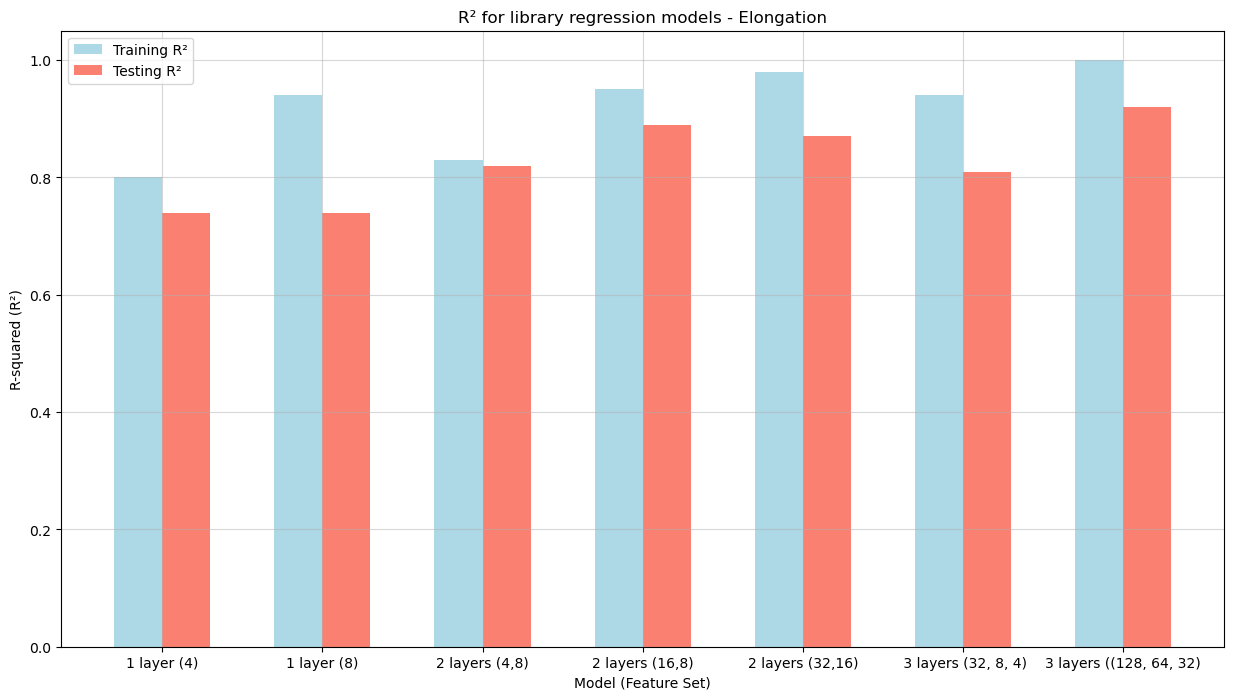

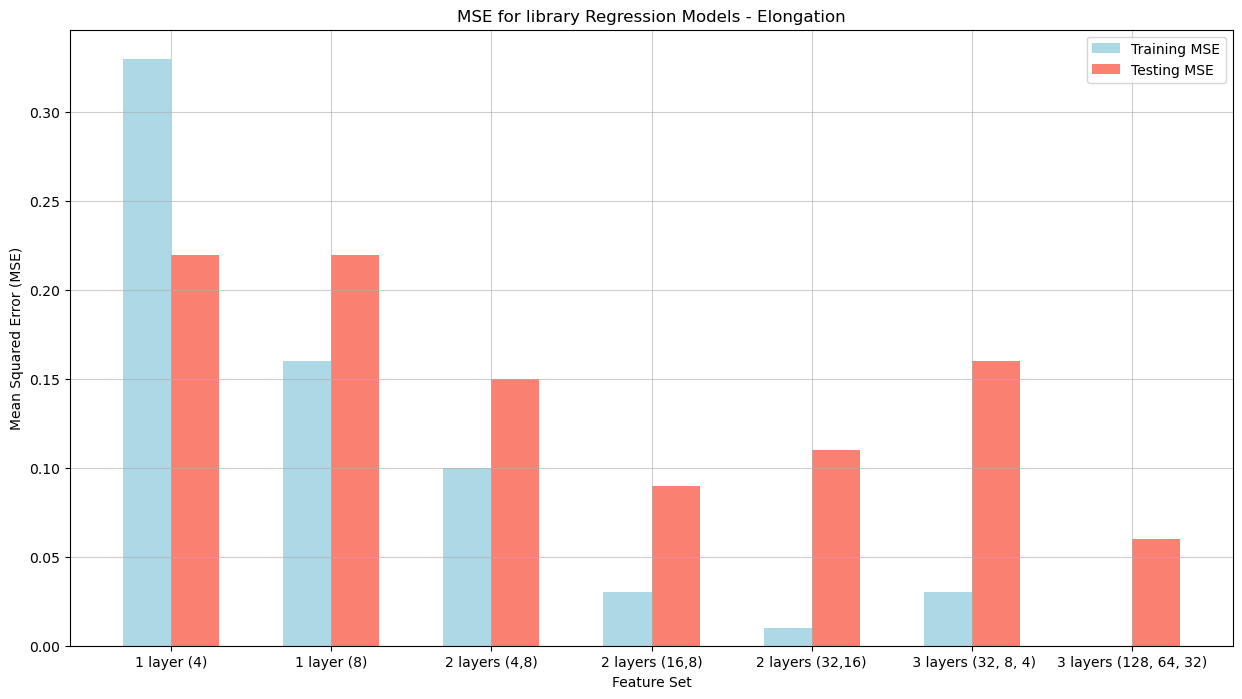

In [70]:
#Correation values for all the models 
r2_data = {
    "Model": [  "1 layer (4)", "1 layer (8)", "2 layers (4,8)","2 layers (16,8)", "2 layers (32,16)", " 3 layers (32, 8, 4)","3 layers ((128, 64, 32)"],
    "Degree": [ 2,2,2,2, 2, 2, 2],
    "Train R2": [0.8, 0.94, 0.83, 0.95, 0.98, 0.94, 1, ],  
    "Test R2":  [ 0.74,0.74,  0.82, 0.89, 0.87, 0.81,  0.92,] } 

r2_df = pd.DataFrame(r2_data)#Making the above in[uted R^2 values as dataframes

x_labels = r2_df["Model"].values
x = np.arange(len(x_labels))
y = df['elongation']
width = 0.30

plt.figure(figsize=(15,8))
plt.bar(x - width/2, r2_df["Train R2"], width, label='Training R²', color='lightblue')
plt.bar(x + width/2, r2_df["Test R2"], width, label='Testing R²', color='salmon')

plt.xticks(x, x_labels)
plt.xlabel("Model (Feature Set)")
plt.ylabel("R-squared (R²)")
plt.title("R² for library regression models - Elongation")
plt.legend()
plt.grid(True, linestyle='-', alpha=0.5)
plt.show()
#MSE Values bar chart comparison
data = {
    "Model": [ "1 layer (4)", "1 layer (8)", "2 layers (4,8)","2 layers (16,8)", "2 layers (32,16)", " 3 layers (32, 8, 4)", "3 layers (128, 64, 32)"],
    "Degree": [ 2, 2, 2, 2, 2, 2 ,2 ],
    "Train MSE": [0.33,0.16,  0.1, 0.03, 0.01, 0.03, 0.0,],
    "Test MSE": [0.22, 0.22, 0.15, 0.09, 0.11, 0.16, 0.06, ] } 

mse_df = pd.DataFrame(data)

# Ploting
x_labels = mse_df["Model"].values
x = np.arange(len(x_labels))
width = 0.30

plt.figure(figsize=(15, 8))
plt.bar(x - width/2, mse_df["Train MSE"], width, label='Training MSE', color='lightblue')
plt.bar(x + width/2, mse_df["Test MSE"], width, label='Testing MSE', color='salmon')

plt.xticks(x, x_labels)
plt.xlabel("Feature Set")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE for library Regression Models - Elongation")
plt.legend()
plt.grid(True, linestyle='-', alpha=0.6)
plt.show()

For all the models the hyperparameter random state and the test split was kept constant. The only changes to the models was the layer size, layer number and regulisation strength. This was done to help to pick the best combination of layers and their sizes. 
Analysis of different layers:

* 1 Layer(4 units)-Underfitting: Thia model demonstarates relatively low R^2 for both traaining and testing sets,0.8 and 0.74 respectivelt while simultaneously displaying high MSE values. This suggests that the model is too simple to capture the complexity of the data,resulting in underfitting. However 1 layer with the layer size of 8 starts to show the overfitting properties. 
* 2 Layers(4,8)- This model provides a better generalization(Train R^2=0.83,Test R^2=0.82).MSE values are lower compared to single layer suggesting that this is a better model.
* 2 Layers(16,8)-With a high train R^2 of 0.95 and Test of 0.89, this model performs well, However drop in testing performance compared to training suggests the beginning of overfitting.
* 2 Layers(32,16)-R^2 increases further to 0.98 while test R^2 drops to 0.87, Although performance remains high,increase in gap between training and testing set indicates overfitting.
* 3 Layers(32,8,4)- This deeper model performs well on training data(R^2=0.94) but test R^2 drops to 0.81. Training error(MSE=0.3) is low hpwever test error increases, confirming overfitting.
* 3 Layers(128,64,32)-This model achieves a near perfect training R^2 of 1.0 but test R^2=0.92,tjis difference along with Test MSE=0.06 higher than training MSE=0.00 , is a strong sign of overfitting due to excessive model complexity.


To avoid overfitting various models and depths were tested,alpha=0.001 was applied to models that did not show great overfitting, and for models with higher overfitting alpha of 0.1 was applied (regularization) to reduce overfitting risk. However overfitting ewas still present. 
Models were evaluated using R^2,MAE and MSE to decide the best fit.

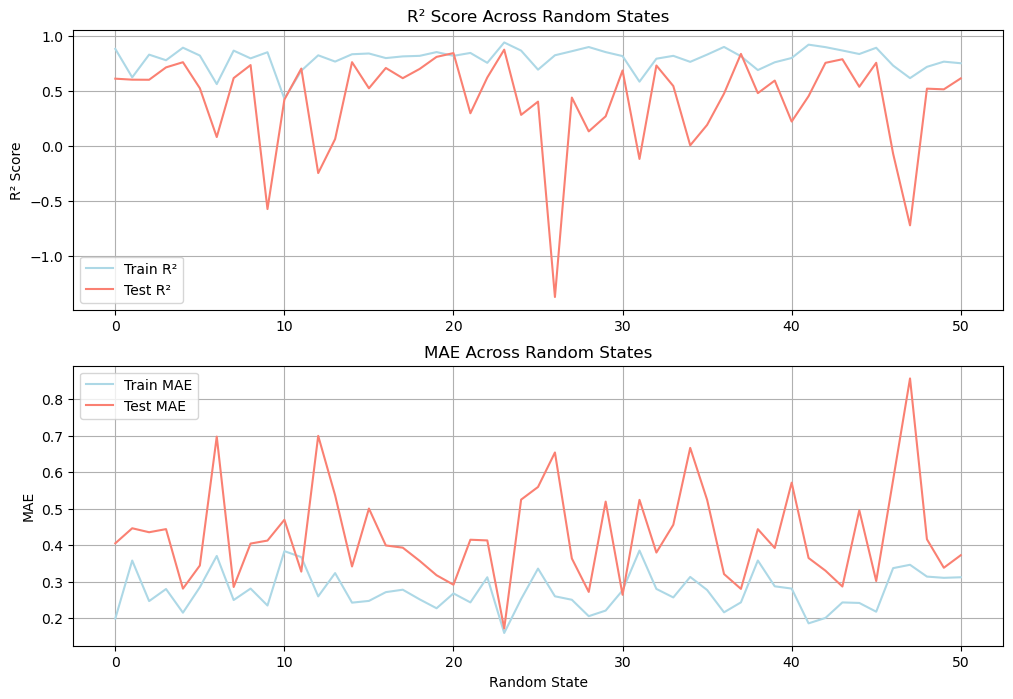

In [52]:
results = []

#selecting the best hyperparameter by looping and plotting random state 
for seed in range(51):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)#doing the required test train set split 
    
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', MLPRegressor(hidden_layer_sizes=(4), activation='relu', solver='adam', max_iter=5000, random_state=seed))])
    
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    results.append({ #adding the calculated results 
        'random_state': seed,
        'train_r2': r2_score(y_train, y_train_pred),
        'test_r2': r2_score(y_test, y_test_pred),
        'train_mae': mean_absolute_error(y_train, y_train_pred),
        'test_mae': mean_absolute_error(y_test, y_test_pred)})

#convert to Dataframe
results_df = pd.DataFrame(results)

#Plotting
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

#R2 Trends
axs[0].plot(results_df['random_state'], results_df['train_r2'], label='Train R²', color='lightblue')
axs[0].plot(results_df['random_state'], results_df['test_r2'], label='Test R²', color='salmon')
axs[0].set_title('R² Score Across Random States')
axs[0].set_ylabel('R² Score')
axs[0].legend()
axs[0].grid(True)

#MAE Trends
axs[1].plot(results_df['random_state'], results_df['train_mae'], label='Train MAE', color='lightblue')
axs[1].plot(results_df['random_state'], results_df['test_mae'], label='Test MAE', color='salmon')
axs[1].set_title('MAE Across Random States')
axs[1].set_xlabel('Random State')
axs[1].set_ylabel('MAE')
axs[1].legend()
axs[1].grid(True)
plt.show()

Generalization and Random state analysis- 
Training R^2 is consistently high(typically above 0.8) suggesting that the model is consistently learning data well regardless of the random state.
Test R^2 fluctuates significantly,ocasionally dropping below 0 indicating poor generalization on some splits.
MAE for training set remains relatively stable and low showing consistent training performance.
MAE for testing set shows variation ,once again suggesting potential generalization issues.
Overall,while the performs well the generalization issues could be arising due to the size of the dataset, ehich is relatively small. Random state of 8 was selected for the Neural network models in this notebooks, as it optimises both training and testing sets.

Scatter plots for predictive vs actual were made for all the layers, to get an understanding of the best choice for layers.

Elongation-with one layer(4)

Training Set:
Mean Absolute Error (MAE): 0.28
Mean Squared Error (MSE): 0.11
Root Mean Squared Error (RMSE) : 0.33
R-squared (R²): 0.80

Testing Set:
Mean Absolute Error (MAE) : 0.40
Mean Squared Error (MSE) : 0.22
Root Mean Squared Error (RMSE): 0.47
R-squared (R²) : 0.74


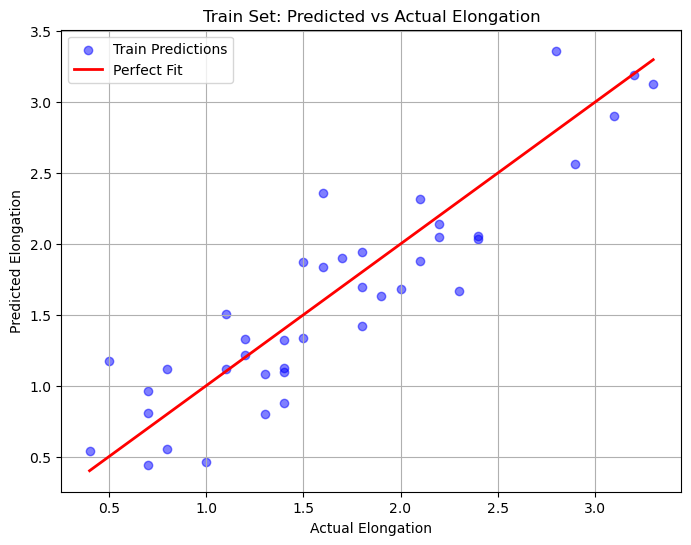

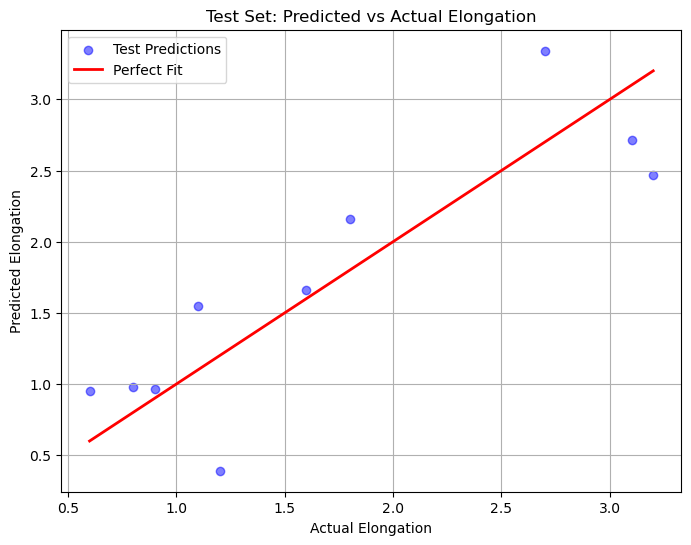

In [68]:

deep_model = Pipeline(steps=[
    ('preprocessor', preprocessor), #processes the data
    ('regressor', MLPRegressor(      #fits the NN
        hidden_layer_sizes=(4),      #tells the size of the hidden layer
        activation='relu',        #uses activation function ReLu to introduce non linearity 
        solver='adam',            #using adaptive optimiser
        alpha=0.001,              #L2 ridge regurisation strength       
        early_stopping=True,       #stops the model when it no longer improves        
        max_iter=2000,             #number of max training iterations
        random_state=8))])         #hyperparameter set earlier 


#defining deep neural network model 
deep_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor(hidden_layer_sizes=(4),  activation='relu', solver='adam',max_iter=2000, random_state=8))])                                                                                            # Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

#train the model
deep_model.fit(X_train, y_train)

#predictions
y_train_pred = deep_model.predict(X_train)
y_test_pred = deep_model.predict(X_test)

#evaluation of the model 
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

#Printing
print("Elongation-with one layer(4)")
print("\nTraining Set:")
print(f"Mean Absolute Error (MAE): {mae_train:.2f}")
print(f"Mean Squared Error (MSE): {mse_train:.2f}")
print(f"Root Mean Squared Error (RMSE) : {rmse_train:.2f}")
print(f"R-squared (R²): {r2_train:.2f}")

print("\nTesting Set:")
print(f"Mean Absolute Error (MAE) : {mae_test:.2f}")
print(f"Mean Squared Error (MSE) : {mse_test:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_test:.2f}")
print(f"R-squared (R²) : {r2_test:.2f}")

#Scatter Plots (Actual vs Predicted)
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_train_pred, color='blue', alpha=0.5, label="Train Predictions")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r-', lw=2, label="Perfect Fit")
plt.xlabel("Actual Elongation")
plt.ylabel("Predicted Elongation")
plt.title("Train Set: Predicted vs Actual Elongation")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='blue', alpha=0.5, label="Test Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r-', lw=2, label="Perfect Fit")
plt.xlabel("Actual Elongation")
plt.ylabel("Predicted Elongation")
plt.title("Test Set: Predicted vs Actual Elongation")
plt.grid(True)
plt.legend()
plt.show()

Elongation-with 2 Layers(8,4)

Training Set:
Mean Absolute Error (MAE): 0.25
Mean Squared Error (MSE): 0.10
Root Mean Squared Error (RMSE) : 0.31
R-squared (R²): 0.83

Testing Set:
Mean Absolute Error (MAE) : 0.36
Mean Squared Error (MSE) : 0.15
Root Mean Squared Error (RMSE): 0.39
R-squared (R²) : 0.82


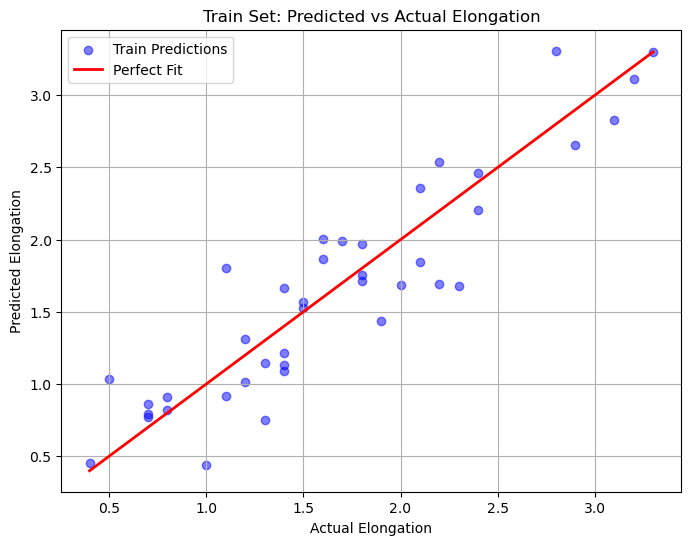

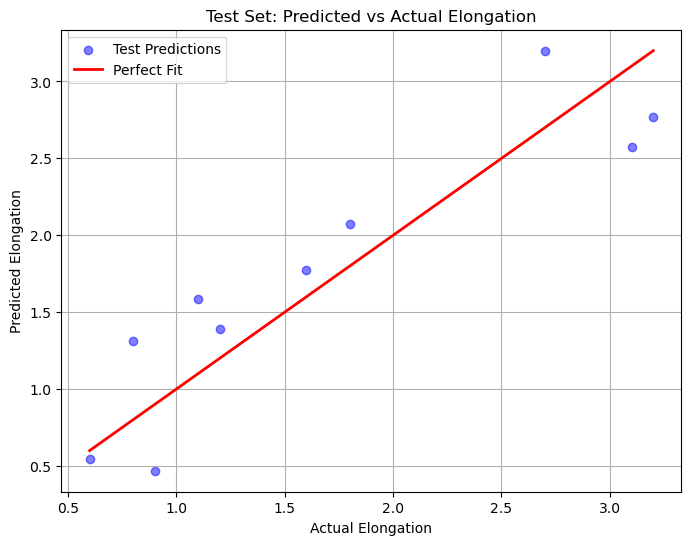

In [73]:

deep_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor(
        hidden_layer_sizes=(8,4), #increasing the number of layers to two and increasing the other layer size to 8
        activation='relu',
        solver='adam',
        alpha=0.1,                       
        early_stopping=True,               
        max_iter=2000,
        random_state=8))])


#define deep neural network model
deep_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor(hidden_layer_sizes=(8,4),  activation='relu', solver='adam',max_iter=2000, random_state=8))])                                                                                            # Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

#Trainingn the model
deep_model.fit(X_train, y_train)

#predictions
y_train_pred = deep_model.predict(X_train)
y_test_pred = deep_model.predict(X_test)

#evaluations of the models
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

#Printing
print("Elongation-with 2 Layers(8,4)")
print("\nTraining Set:")
print(f"Mean Absolute Error (MAE): {mae_train:.2f}")
print(f"Mean Squared Error (MSE): {mse_train:.2f}")
print(f"Root Mean Squared Error (RMSE) : {rmse_train:.2f}")
print(f"R-squared (R²): {r2_train:.2f}")

print("\nTesting Set:")
print(f"Mean Absolute Error (MAE) : {mae_test:.2f}")
print(f"Mean Squared Error (MSE) : {mse_test:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_test:.2f}")
print(f"R-squared (R²) : {r2_test:.2f}")

#Scatter Plots (Actual vs Predicted)
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_train_pred, color='blue', alpha=0.5, label="Train Predictions")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r-', lw=2, label="Perfect Fit")
plt.xlabel("Actual Elongation")
plt.ylabel("Predicted Elongation")
plt.title("Train Set: Predicted vs Actual Elongation")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='blue', alpha=0.5, label="Test Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r-', lw=2, label="Perfect Fit")
plt.xlabel("Actual Elongation")
plt.ylabel("Predicted Elongation")
plt.title("Test Set: Predicted vs Actual Elongation")
plt.grid(True)
plt.legend()
plt.show()

Elongation-2 layers(16,8)

Training Set:
Mean Absolute Error (MAE): 0.12
Mean Squared Error (MSE): 0.03
Root Mean Squared Error (RMSE) : 0.16
R-squared (R²): 0.95

Testing Set:
Mean Absolute Error (MAE) : 0.26
Mean Squared Error (MSE) : 0.09
Root Mean Squared Error (RMSE): 0.30
R-squared (R²) : 0.89


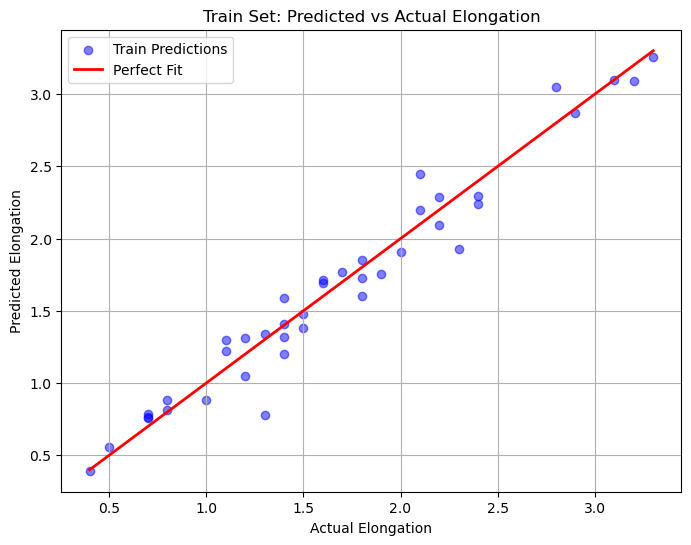

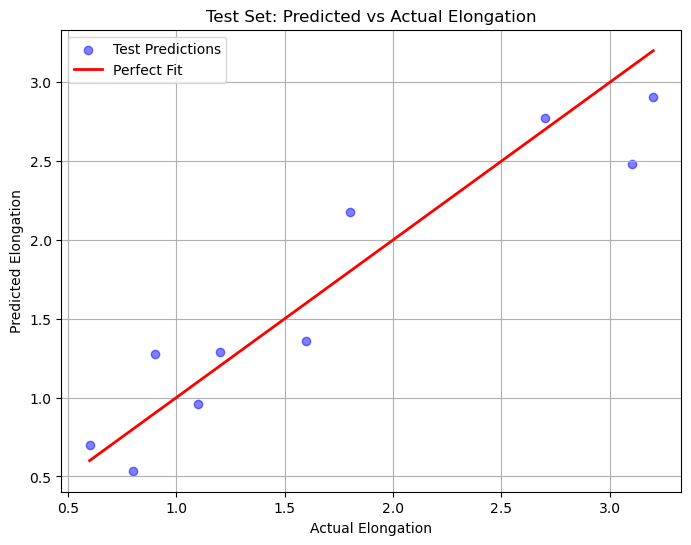

In [60]:

deep_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor(
        hidden_layer_sizes=(16,8), #keeping 2 layers but increasing the layer sizes
        activation='relu',
        solver='adam',
        alpha=0.001,                       
        early_stopping=True,               
        max_iter=2000,
        random_state=8))])


#Define deep neural network model 
deep_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor(hidden_layer_sizes=(16,8),  activation='relu', solver='adam',max_iter=2000, random_state=8))])                                                                                            # Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

#Training the model
deep_model.fit(X_train, y_train)

#predictions
y_train_pred = deep_model.predict(X_train)
y_test_pred = deep_model.predict(X_test)

#evaluation the model
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

#Printing
print("Elongation-2 layers(16,8)")
print("\nTraining Set:")
print(f"Mean Absolute Error (MAE): {mae_train:.2f}")
print(f"Mean Squared Error (MSE): {mse_train:.2f}")
print(f"Root Mean Squared Error (RMSE) : {rmse_train:.2f}")
print(f"R-squared (R²): {r2_train:.2f}")

print("\nTesting Set:")
print(f"Mean Absolute Error (MAE) : {mae_test:.2f}")
print(f"Mean Squared Error (MSE) : {mse_test:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_test:.2f}")
print(f"R-squared (R²) : {r2_test:.2f}")

#Scatter Plots (Actual vs Predicted)
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_train_pred, color='blue', alpha=0.5, label="Train Predictions")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r-', lw=2, label="Perfect Fit")
plt.xlabel("Actual Elongation")
plt.ylabel("Predicted Elongation")
plt.title("Train Set: Predicted vs Actual Elongation")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='blue', alpha=0.5, label="Test Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r-', lw=2, label="Perfect Fit")
plt.xlabel("Actual Elongation")
plt.ylabel("Predicted Elongation")
plt.title("Test Set: Predicted vs Actual Elongation")
plt.grid(True)
plt.legend()
plt.show()

 Elongation 2 layers(32,16)

Training Set:
Mean Absolute Error (MAE): 0.08
Mean Squared Error (MSE): 0.01
Root Mean Squared Error (RMSE) : 0.10
R-squared (R²): 0.98

Testing Set:
Mean Absolute Error (MAE) : 0.29
Mean Squared Error (MSE) : 0.11
Root Mean Squared Error (RMSE): 0.34
R-squared (R²) : 0.87


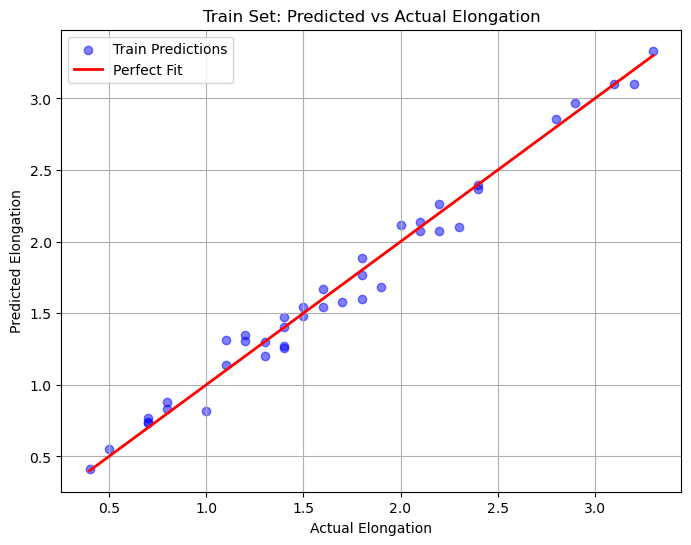

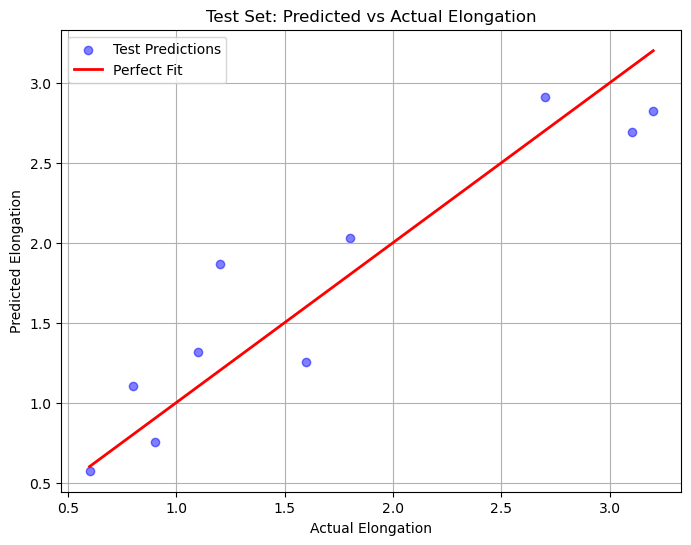

In [83]:

deep_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor(
        hidden_layer_sizes=(32, 16), #layers 0f 16 and 32 used 
        activation='relu',
        solver='adam',
        alpha=0.1,                       
        early_stopping=True,               
        max_iter=2000,
        random_state=8))])
#Define deeper neural network model
deep_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor(hidden_layer_sizes=( 32, 16),  activation='relu', solver='adam',max_iter=2000, random_state=8))])                                                                                            # Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

#Train the model
deep_model.fit(X_train, y_train)

#predictions
y_train_pred = deep_model.predict(X_train)
y_test_pred = deep_model.predict(X_test)

#evaluation
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

#Printing
print(" Elongation 2 layers(32,16)")
print("\nTraining Set:")
print(f"Mean Absolute Error (MAE): {mae_train:.2f}")
print(f"Mean Squared Error (MSE): {mse_train:.2f}")
print(f"Root Mean Squared Error (RMSE) : {rmse_train:.2f}")
print(f"R-squared (R²): {r2_train:.2f}")

print("\nTesting Set:")
print(f"Mean Absolute Error (MAE) : {mae_test:.2f}")
print(f"Mean Squared Error (MSE) : {mse_test:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_test:.2f}")
print(f"R-squared (R²) : {r2_test:.2f}")

#Scatter Plots (Actual vs Predicted)
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_train_pred, color='blue', alpha=0.5, label="Train Predictions")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r-', lw=2, label="Perfect Fit")
plt.xlabel("Actual Elongation")
plt.ylabel("Predicted Elongation")
plt.title("Train Set: Predicted vs Actual Elongation")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='blue', alpha=0.5, label="Test Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r-', lw=2, label="Perfect Fit")
plt.xlabel("Actual Elongation")
plt.ylabel("Predicted Elongation")
plt.title("Test Set: Predicted vs Actual Elongation")
plt.grid(True)
plt.legend()
plt.show()




Now trying with 3 hidden layers. 


Elongation-3 layers(32,8,4)

Training Set:
Mean Absolute Error (MAE): 0.14
Mean Squared Error (MSE): 0.03
Root Mean Squared Error (RMSE) : 0.18
R-squared (R²): 0.94

Testing Set:
Mean Absolute Error (MAE) : 0.32
Mean Squared Error (MSE) : 0.16
Root Mean Squared Error (RMSE): 0.40
R-squared (R²) : 0.81


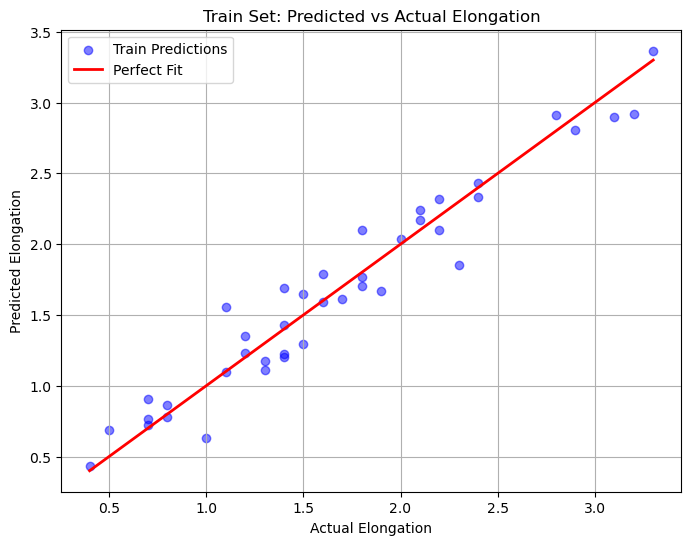

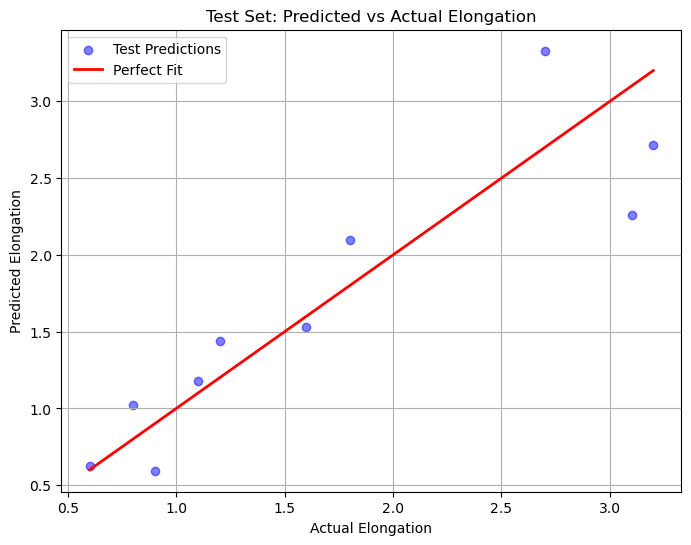

In [81]:

#Defining deeper neural network model with 3 hidden layers
deep_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor(
        hidden_layer_sizes=(32, 8, 4),#using 3 layers of this sizes
        activation='relu',
        solver='adam',
        alpha=0.1,                       
        early_stopping=True,               
        max_iter=2000,
        random_state=8))])


#Defining deep neural network model 
deep_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor(hidden_layer_sizes=( 32, 8, 4),  activation='relu', solver='adam',max_iter=2000, random_state=8))])                                                                                            # Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8) 

#Train the model
deep_model.fit(X_train, y_train)

#predictions
y_train_pred = deep_model.predict(X_train)
y_test_pred = deep_model.predict(X_test)

#evaluation the model 
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

#Printing
print("Elongation-3 layers(32,8,4)")
print("\nTraining Set:")
print(f"Mean Absolute Error (MAE): {mae_train:.2f}")
print(f"Mean Squared Error (MSE): {mse_train:.2f}")
print(f"Root Mean Squared Error (RMSE) : {rmse_train:.2f}")
print(f"R-squared (R²): {r2_train:.2f}")

print("\nTesting Set:")
print(f"Mean Absolute Error (MAE) : {mae_test:.2f}")
print(f"Mean Squared Error (MSE) : {mse_test:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_test:.2f}")
print(f"R-squared (R²) : {r2_test:.2f}")

#Scatter Plots (Actual vs Predicted)
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_train_pred, color='blue', alpha=0.5, label="Train Predictions")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r-', lw=2, label="Perfect Fit")
plt.xlabel("Actual Elongation")
plt.ylabel("Predicted Elongation")
plt.title("Train Set: Predicted vs Actual Elongation")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='blue', alpha=0.5, label="Test Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r-', lw=2, label="Perfect Fit")
plt.xlabel("Actual Elongation")
plt.ylabel("Predicted Elongation")
plt.title("Test Set: Predicted vs Actual Elongation")
plt.grid(True)
plt.legend()
plt.show()

Elongation 3 layers(128,64,32)

Training Set:
Mean Absolute Error (MAE): 0.03
Mean Squared Error (MSE): 0.00
Root Mean Squared Error (RMSE) : 0.03
R-squared (R²): 1.00

Testing Set:
Mean Absolute Error (MAE) : 0.23
Mean Squared Error (MSE) : 0.06
Root Mean Squared Error (RMSE): 0.25
R-squared (R²) : 0.92


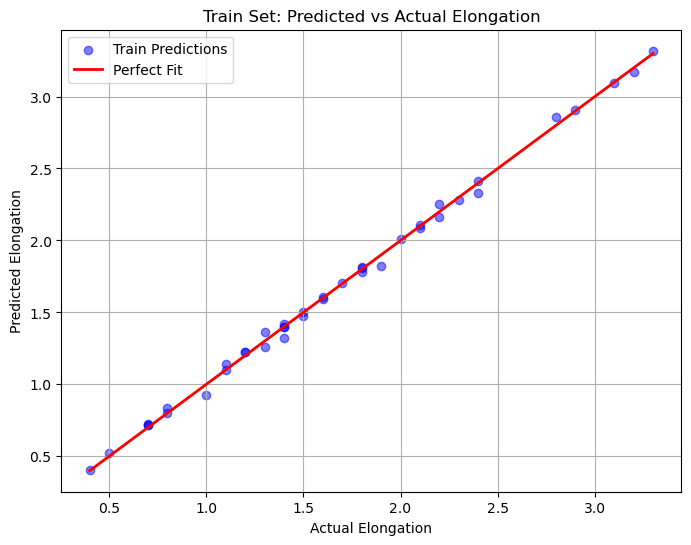

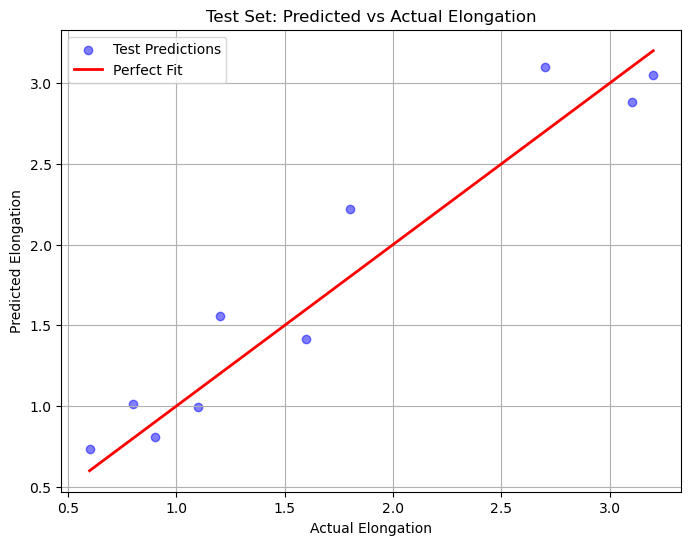

In [79]:

deep_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor(
        hidden_layer_sizes=(128, 64, 32),
        activation='relu',
        solver='adam',
        alpha=0.1,                       
        early_stopping=True,               
        max_iter=2000,
        random_state=8))])


deep_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor(hidden_layer_sizes=(128, 64, 32),  activation='relu', solver='adam',max_iter=2000, random_state=8))])                                                                                            # Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

#train the model
deep_model.fit(X_train, y_train)

#predictions
y_train_pred = deep_model.predict(X_train)
y_test_pred = deep_model.predict(X_test)

#evaluation
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

#Printing
print("Elongation 3 layers(128,64,32)")
print("\nTraining Set:")
print(f"Mean Absolute Error (MAE): {mae_train:.2f}")
print(f"Mean Squared Error (MSE): {mse_train:.2f}")
print(f"Root Mean Squared Error (RMSE) : {rmse_train:.2f}")
print(f"R-squared (R²): {r2_train:.2f}")

print("\nTesting Set:")
print(f"Mean Absolute Error (MAE) : {mae_test:.2f}")
print(f"Mean Squared Error (MSE) : {mse_test:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_test:.2f}")
print(f"R-squared (R²) : {r2_test:.2f}")

#Scatter Plots (Actual vs Predicted)
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_train_pred, color='blue', alpha=0.5, label="Train Predictions")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r-', lw=2, label="Perfect Fit")
plt.xlabel("Actual Elongation")
plt.ylabel("Predicted Elongation")
plt.title("Train Set: Predicted vs Actual Elongation")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='blue', alpha=0.5, label="Test Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r-', lw=2, label="Perfect Fit")
plt.xlabel("Actual Elongation")
plt.ylabel("Predicted Elongation")
plt.title("Test Set: Predicted vs Actual Elongation")
plt.grid(True)
plt.legend()
plt.show()